<a href="https://colab.research.google.com/github/Kassra-sinaei/simple_humanoid_leg_kinematics/blob/main/DCM_Trajectory_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desired DCM Trajectory Generation

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicHermiteSpline, CubicSpline

<b> Input Design Parameters</b><br>
*!!!sample time 0.01s!!!*<br>
*Walking speed: 1.8km/hr*

In [91]:
delta_z = 0.8
g = 9.81
t_step = 1.0
#t_ss = 1.0
t_ds = 0.4
alpha = 0.5

<b> Foot Placements </b>
<br> <i> ** flat surface </i>

In [59]:
rF =np.array([[0.0,0.115,0.0],
             [0.0,-0.115,0.0],
             [0.5,0.115,0.0],
             [1.0,-0.115,0.0],
             [1.5,0.115,0.0],
             [2.0,-0.115,0.0],
             [2.5,0.115,0.0]])

<b> Virtual Repellant Point </b>

In [60]:
rVRP = np.copy(rF)
rVRP[:,2] += delta_z

[[ 0.0155402  -0.10826986  0.8       ]
 [ 0.51554018  0.10826987  0.8       ]
 [ 1.01553977 -0.10826968  0.8       ]
 [ 1.51552608  0.10827598  0.8       ]
 [ 2.01507176 -0.10806699  0.8       ]
 [ 2.5         0.115       0.8       ]
 [ 2.5         0.115       0.8       ]]


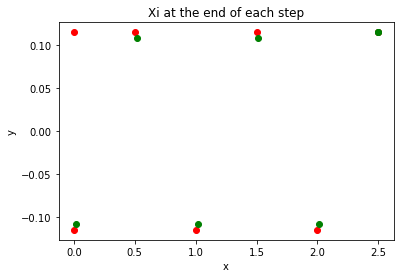

In [61]:
xi_eos = np.copy(rVRP)
xi_eos[-1] = rVRP[-1]
for index in range(np.size(rVRP,0)-2,-1,-1):
    xi_eos[index] = rVRP[index+1] + math.exp(-math.sqrt(g/delta_z) * t_step) * (xi_eos[index+1] - rVRP[index+1])
print(xi_eos)
plt.scatter(rF[:,0],rF[:,1],color=['red'])
plt.scatter(xi_eos[:,0],xi_eos[:,1],color = ['green'])
plt.title('Xi at the end of each step')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<b> 3D DCM Trajectory without CDS </b>

In [62]:
xi_d = list('')
dt = 100        # 1/dt
for iter in range(int(dt * t_step * rF.shape[0])):
    time = iter / dt
    i = int(time / t_step)
    t = time % (t_step)
    xi_d.append(rVRP[i] + math.exp(math.sqrt(g/delta_z) * (t - t_step)) * (xi_eos[i] - rVRP[i]))

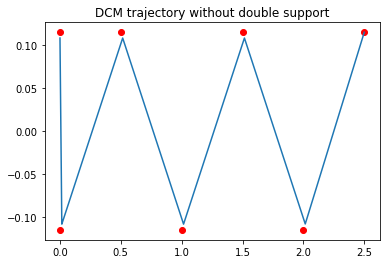

In [63]:
xi_d = np.array(xi_d)
plt.plot(xi_d[:,0],xi_d[:,1])
plt.scatter(rF[:,0],rF[:,1],color=['red'])
plt.title('DCM trajectory without double support')
plt.show()

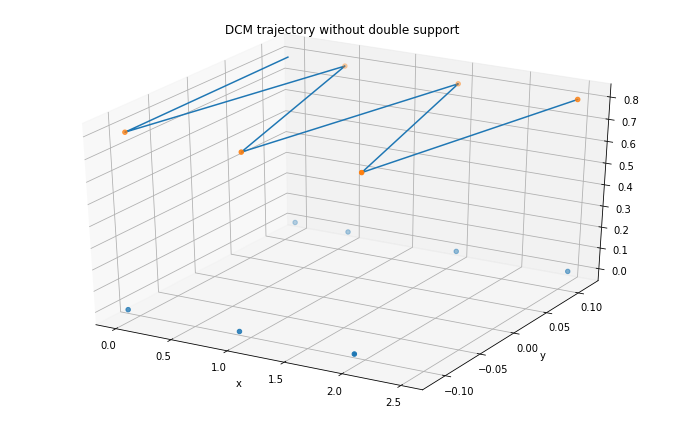

In [64]:
fig = plt.figure(figsize=(12,7.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xi_d[:,0],xi_d[:,1],xi_d[:,2])
ax.scatter3D(rF[:,0],rF[:,1],rF[:,2])
ax.scatter3D(xi_eos[:,0],xi_eos[:,1],xi_eos[:,2])
plt.title('DCM trajectory without double support')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<b>Adding Continuous Double Support</b>

In [92]:
xi_ds_i = np.zeros((np.size(rF,0),3))
xi_ds_e = np.zeros((np.size(rF,0),3))
for index in range(np.size(rVRP,0)):
    if index == 0:
        xi_ds_i[index] = xi_d[0]
        xi_ds_e[index] = rVRP[index] + math.exp(math.sqrt(g/delta_z) * t_ds * (1-alpha)) * (xi_d[0] - rVRP[index])
    else:
        xi_ds_i[index] = rVRP[index-1] + math.exp(-math.sqrt(g/delta_z) * t_ds * alpha) * (xi_eos[index-1] - rVRP[index-1])
        xi_ds_e[index] = rVRP[index] +   math.exp( math.sqrt(g/delta_z) * t_ds * (1-alpha)) * (xi_eos[index-1] - rVRP[index])


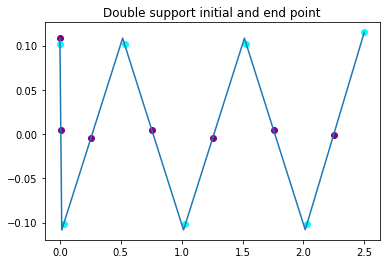

In [93]:
xi_d = np.array(xi_d)
plt.plot(xi_d[:,0],xi_d[:,1])
plt.scatter(xi_ds_i[:,0],xi_ds_i[:,1],color=['purple'])
plt.scatter(xi_ds_e[:,0],xi_ds_e[:,1],color=['cyan'])
plt.title('Double support initial and end point')
plt.show()

In [78]:
from scipy.optimize import fsolve

def interpolate(xi_ini, xi_end, xi_dot_ini, xi_dot_end):
    def func(x):
        """
            xi =         a * t**3 +     b * t**2 + c * t**1 + d
            xi_dot = 3 * a * t**2 + 2 * b * t    + c
        """
        #t = t_ds * (1 - alpha)
        t = t_ds
        a = np.array([x[0],x[1],x[2]])
        b = np.array([x[3],x[4],x[5]])
        c = np.array([x[6],x[7],x[8]])
        d = np.array([x[9],x[10],x[11]])
        return([(a*t**3 + b*t**2 + c*t + d - xi_end)[0],
                (a*t**3 + b*t**2 + c*t + d - xi_end)[1],
                (a*t**3 + b*t**2 + c*t + d - xi_end)[2],
                (d - xi_ini)[0],
                (d - xi_ini)[1],
                (d - xi_ini)[2],
                (3*a*t**2 + 2*b*t + c - xi_dot_end)[0],
                (3*a*t**2 + 2*b*t + c - xi_dot_end)[1],
                (3*a*t**2 + 2*b*t + c - xi_dot_end)[2],
                (c - xi_dot_ini)[0],
                (c - xi_dot_ini)[1],
                (c - xi_dot_ini)[2]])
        
    root = fsolve(func,1*np.ones(12))
    return root

In [94]:
CDS_coefs = list('')
for i in range(np.size(rVRP,0)):
    if i == 0:
        xi_dot_i = (xi_ds_i[i] - xi_d[0]) * math.sqrt(g/delta_z)
        xi_dot_e = (xi_ds_e[i] - rVRP[0]) * math.sqrt(g/delta_z)
    else:
        xi_dot_i = (xi_ds_i[i] - rVRP[i-1]) * math.sqrt(g/delta_z)
        xi_dot_e = (xi_ds_e[i] - rVRP[i]) * math.sqrt(g/delta_z)
    CDS_coefs.append(interpolate(xi_ds_i[i],xi_ds_e[i], xi_dot_i, xi_dot_e))

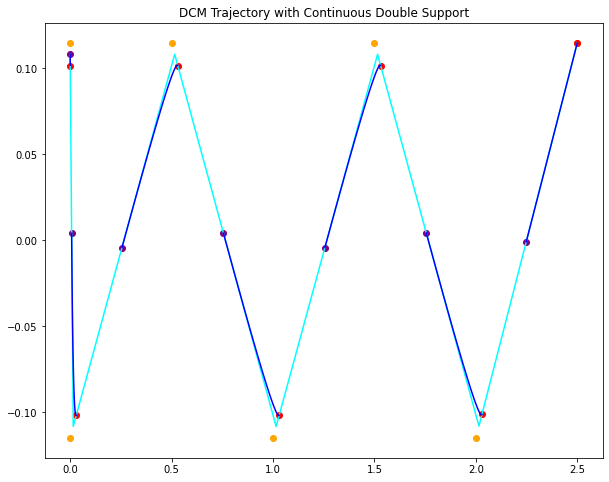

In [95]:
ds_trajectory = list('')
from matplotlib.pyplot import gcf
fig =gcf()
fig.set_size_inches(10,8)

plt.plot(xi_d[:,0],xi_d[:,1],color='cyan')

for i in range(len(CDS_coefs)):
    a = np.array([CDS_coefs[i][0],CDS_coefs[i][1],CDS_coefs[i][2]])
    b = np.array([CDS_coefs[i][3],CDS_coefs[i][4],CDS_coefs[i][5]])
    c = np.array([CDS_coefs[i][6],CDS_coefs[i][7],CDS_coefs[i][8]])
    d = np.array([CDS_coefs[i][9],CDS_coefs[i][10],CDS_coefs[i][11]])
    CDS_trajectory = np.zeros((int(t_ds*dt),3))
    for t in range(int(t_ds*dt)):
        CDS_trajectory[t] = a * (t/dt)**3 + b * (t/dt)**2 + c * (t/dt) + d
    plt.plot(CDS_trajectory[:,0],CDS_trajectory[:,1],color='blue')

plt.scatter(rF[:,0],rF[:,1],color=['orange'])
plt.scatter(xi_ds_i[:,0],xi_ds_i[:,1],color=['purple'])
plt.scatter(xi_ds_e[:,0],xi_ds_e[:,1],color=['red'])
plt.title('DCM Trajectory with Continuous Double Support')  
plt.show()

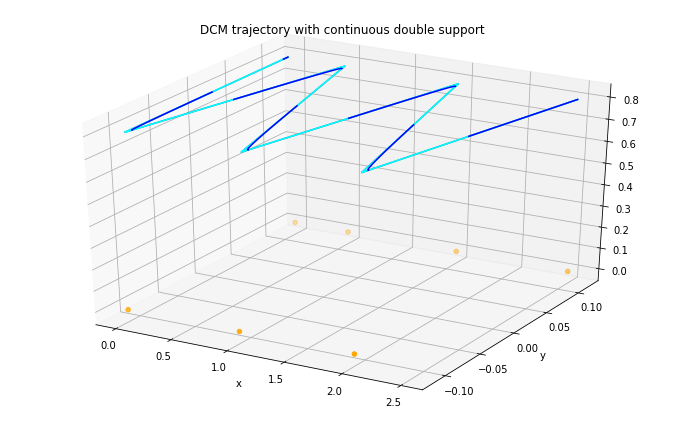

In [96]:
fig = plt.figure(figsize=(12,7.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xi_d[:,0],xi_d[:,1],xi_d[:,2])
plt.plot(xi_d[:,0],xi_d[:,1],xi_d[:,2],color='cyan')

xi_cds = list('')

for i in range(len(CDS_coefs)):
    a = np.array([CDS_coefs[i][0],CDS_coefs[i][1],CDS_coefs[i][2]])
    b = np.array([CDS_coefs[i][3],CDS_coefs[i][4],CDS_coefs[i][5]])
    c = np.array([CDS_coefs[i][6],CDS_coefs[i][7],CDS_coefs[i][8]])
    d = np.array([CDS_coefs[i][9],CDS_coefs[i][10],CDS_coefs[i][11]])
    CDS_trajectory = np.zeros((int(t_ds*dt),3))
    for t in range(int(t_ds*dt)):
        CDS_trajectory[t] = a * (t/dt)**3 + b * (t/dt)**2 + c * (t/dt) + d
    plt.plot(CDS_trajectory[:,0],CDS_trajectory[:,1],CDS_trajectory[:,2],color='blue')
    xi_cds.append(CDS_trajectory)           # This will be used for merging single support trajectory and double support trajectory

ax.scatter3D(rF[:,0],rF[:,1],rF[:,2],color=['orange'])
plt.title('DCM trajectory with continuous double support')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Merging CDS and SS Trajectories to Generate Final DCM Trajectory

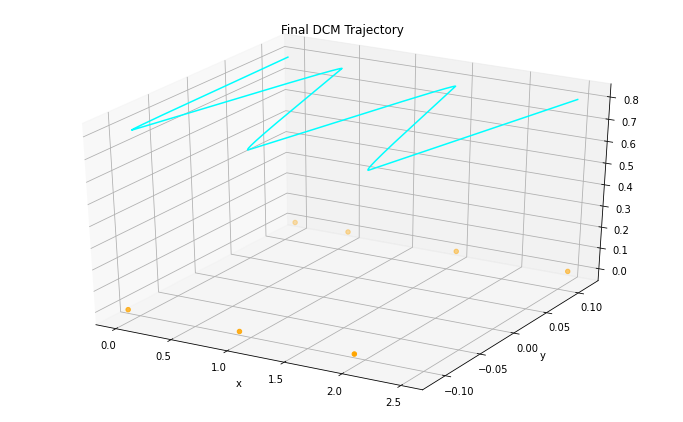

In [99]:
xi_final = np.array(xi_d)
for step in range(rVRP.shape[0]):
    if step == 0:
        xi_final[:int(t_ds * (1-alpha) *dt)] = xi_cds[0][:int((1-alpha)*dt*t_ds)]
    else: 
        xi_final[int(dt * t_step * step - (t_ds * alpha *dt)):int(dt * t_step * step +(t_ds * (1-alpha) *dt)-1)] = xi_cds[step][1:]

fig = plt.figure(figsize=(12,7.5))
ax = fig.add_subplot(111, projection='3d')
plt.plot(xi_final[:,0],xi_final[:,1],xi_final[:,2],color='cyan')


ax.scatter3D(rF[:,0],rF[:,1],rF[:,2],color=['orange'])
plt.title('Final DCM Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Deriving COM Trajectory From Desired DCM 
<br> <i>Analytical Solution</i>

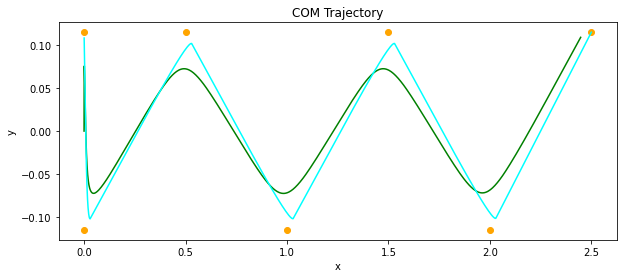

In [100]:
COM = np.zeros_like(xi_final)

COM[0] = [0,0,0.8] 
for index in range(1,COM.shape[0]):
    inte = np.zeros((3))
    for t in range(index):
        inte += (1/100) * xi_final[t] * math.exp((t/100)/(math.sqrt(delta_z/g)))
    #COM[index] = xi_final[index] + ([0,0,0] - xi_final[0]) * math.exp(-(index/100)/(math.sqrt(delta_z/g)))
    COM[index] = (inte / math.sqrt(delta_z/g) + COM[0]) * math.exp((-index/100)/math.sqrt(delta_z/g))

fig =gcf()
fig.set_size_inches(10,4)

plt.scatter(rF[:,0],rF[:,1],color=['orange'])
plt.plot(COM[:,0],COM[:,1],color = 'green')
plt.plot(xi_final[:,0],xi_final[:,1],color='cyan')
plt.title('COM Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

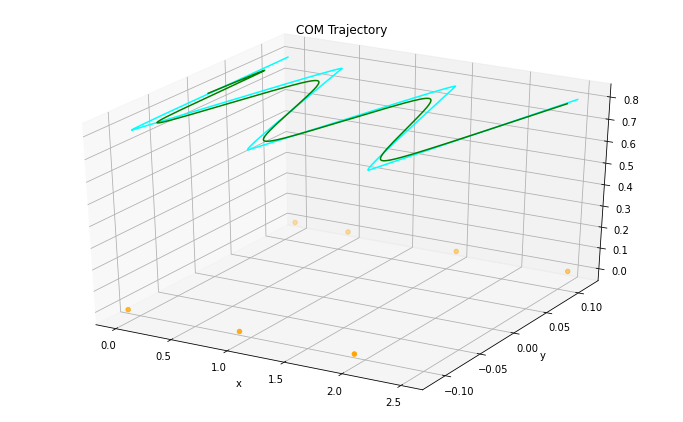

In [101]:
fig = plt.figure(figsize=(12,7.5))
ax = fig.add_subplot(111, projection='3d')


plt.plot(xi_final[:,0],xi_final[:,1],xi_final[:,2],color='cyan')
ax.scatter3D(rF[:,0],rF[:,1],rF[:,2],color=['orange'])
plt.plot(COM[:,0],COM[:,1],COM[:,2],color = 'green')
plt.title('COM Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.show()